In [3]:
using Pkg
Pkg.activate()
Pkg.instantiate()
using MixedModels
using RCall
using DataFrames, Tables
using Random
using CSV
using RData
using CategoricalArrays
using Statistics
using Dates

 Activating environment at `C:\Users\bjoer\.julia\environments\v1.4\Project.toml`



R version 3.6.1 (2019-07-05) -- "Action of the Toes"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



In [27]:

ConditionOfInterest = [0;1]
StandardValues = [5;8]
reps = 55
PSE_Difference = 0.1
JND_Difference = 0.3
Multiplicator_PSE_Standard = 0
Multiplicator_SD_Standard = 0.108
SD_ResponseFunction = 0.1
Mean_Variability_Between = 0.1
SD_Variability_Between = 0.1
nIterations = 100
nParticipants = 10

#function = SimulatePsychometricFunction_Staircase(ID, 
#                                                  ConditionOfInterest, 
#                                                  StandardValues, 
#                                                  reps, 
#                                                  PSE_Difference, 
#                                                  JND_Difference, 
#                                                  Multiplicator_PSE_Standard, 
#                                                  Multiplicator_SD_Standard, 
#                                                  SD_ResponseFunction, 
#                                                  Mean_Variability_Between, 
#                                                  SD_Variability_Between)

ID=[]
for i in 1:nParticipants
    ID = [ID;string(i)]
end

for i in ID
    for j in ConditionOfInterest
        for k in StandardValues
            for l in 1:reps
                if i == ID[1] && j == ConditionOfInterest[1] && k == StandardValues[1] && l == 1
                    global Psychometric = DataFrame(ID=i,ConditionOfInterest=j,StandardValues=k,reps=l)
                else
                    row = DataFrame(ID=i,ConditionOfInterest=j,StandardValues=k,reps=l)
                    Psychometric = append!(Psychometric,row)
                end
            end
        end
    end
end



,ID,ConditionOfInterest,StandardValues,reps
,String,Int64,Int64,Int64
1,1,0,5,1
2,1,0,5,2
3,1,0,5,3
4,1,0,5,4
5,1,0,5,5
6,1,0,5,6
7,1,0,5,7
8,1,0,5,8
9,1,0,5,9


In [23]:
function SimulateDataframe(n,
        ConditionOfInterest,
        StandardValues,
        reps,
        PSE_Difference,
        JND_Difference,
        Multiplicator_PSE_Standard,
        Multiplicator_SD_Standard,
        SD_ResponseFunction,
        Mean_Variability_Between,
        SD_Variability_Between)
    
    @rput n ConditionOfInterest StandardValues reps PSE_Difference JND_Difference Multiplicator_PSE_Standard Multiplicator_SD_Standard SD_ResponseFunction Mean_Variability_Between SD_Variability_Between

    R"""
    ID = paste0("s",1:n)
        Psychometric = SimulatePsychometricFunction_Staircase(ID,
            ConditionOfInterest,
            StandardValues,
            1:reps,
            PSE_Difference,
            JND_Difference,
            Multiplicator_PSE_Standard,
            Multiplicator_SD_Standard,
            SD_ResponseFunction,
            Mean_Variability_Between,
            SD_Variability_Between)
    """;
    
    @rget Psychometric
    
    Psychometric[:StandardValuesAsFactor] = "placeholder"
    
    for i = 1:length(Psychometric[!,:StandardValues])
        Psychometric[i,:StandardValuesAsFactor] = string(Psychometric[i,:StandardValues])
    end
    
    Psychometric[!,:StandardValuesAsFactor] = CategoricalArray(Psychometric[!,:StandardValuesAsFactor])
    Psychometric

end

SimulateDataframe (generic function with 1 method)

In [26]:
function GLMM_Accuracy(Psychometric)
    formulaAccuracy = @formula(Answer ~ 1 + ConditionOfInterest + (1 + Difference|ID) + (1 + Difference|StandardValuesAsFactor));
    modelAccuracy = GeneralizedLinearMixedModel(formulaAccuracy, Psychometric, Bernoulli())
(coeftable(modelAccuracy)).cols[4][2]
end

function GLMM_Precision(Psychometric)
    formula1 = @formula(Answer ~ Difference*ConditionOfInterest + (Difference|ID) + (Difference|StandardValuesAsFactor));
    modelPrecision = fit!(GeneralizedLinearMixedModel(formula1, Psychometric, Binomial()), fast=true)
(coeftable(modelPrecision)).cols[4][4]
end

GLMM_Precision (generic function with 1 method)

In [95]:
ConditionOfInterest = [0;1]
StandardValues = [5;8]
Range_reps = [40,60]
PSE_Difference = 0.1
JND_Difference = 0.3
Multiplicator_PSE_Standard = 0
Multiplicator_SD_Standard = 0.108
SD_ResponseFunction = 0.1
Mean_Variability_Between = 0.1
SD_Variability_Between = 0.1
nIterations = 100
Range_Participants = [10,12,14,16,18,20]
nIterations = 2

TotalNumber = length(Range_reps)*length(Range_Participants)
CurrentRunthrough = 0
rightnow = Dates.now()

for reps in Range_reps
    for n in Range_Participants
   
        TimeStartTrial = Dates.now()
                
        Pvalues_Accuracy = []
        Pvalues_Precision = []
        Pvalues_Accuracy_TwoLevel = []
        Pvalues_Precision_TwoLevel = []
                
        for j in 1:nIterations
        Psychometric = SimulateDataframe(n, 
                                    ConditionOfInterest, 
                                    StandardValues, 
                                    reps, 
                                    PSE_Difference, 
                                    JND_Difference, 
                                    Multiplicator_PSE_Standard, 
                                    Multiplicator_SD_Standard, 
                                    SD_ResponseFunction, 
                                    Mean_Variability_Between, 
                                    SD_Variability_Between)
        Pvalues_Accuracy = [Pvalues_Accuracy;GLMM_Accuracy(Psychometric)]
        Pvalues_Precision = [Pvalues_Precision;GLMM_Precision(Psychometric)]
        end
                
        CurrentRunthrough = CurrentRunthrough + 1

        if CurrentRunthrough == 1

        global PowerfulDataframe = DataFrame(n=n, 
                        ConditionsOfInterest=length(ConditionOfInterest), 
                        StandardValue1=StandardValues[1],
                        StandardValue2=StandardValues[2], 
                        reps=reps, 
                        PSE_Difference=PSE_Difference, 
                        JND_Difference=JND_Difference, 
                        Multiplicator_PSE_Standard=Multiplicator_PSE_Standard, 
                        Multiplicator_SD_Standard=Multiplicator_SD_Standard, 
                        SD_ResponseFunction=SD_ResponseFunction, 
                        Mean_Variability_Between=Mean_Variability_Between, 
                        SD_Variability_Between=SD_Variability_Between, 
                        power_Accuracy = mean(Pvalues_Accuracy .< 0.05),  
                        power_Precision = mean(Pvalues_Precision .< 0.05))

        else
        row = DataFrame(n=n, 
                        ConditionsOfInterest=length(ConditionOfInterest), 
                        StandardValue1=StandardValues[1],
                        StandardValue2=StandardValues[2], 
                        reps=reps, 
                        PSE_Difference=PSE_Difference, 
                        JND_Difference=JND_Difference, 
                        Multiplicator_PSE_Standard=Multiplicator_PSE_Standard, 
                        Multiplicator_SD_Standard=Multiplicator_SD_Standard, 
                        SD_ResponseFunction=SD_ResponseFunction, 
                        Mean_Variability_Between=Mean_Variability_Between, 
                        SD_Variability_Between=SD_Variability_Between, 
                        power_Accuracy = mean(Pvalues_Accuracy .< 0.05),  
                        power_Precision = mean(Pvalues_Precision .< 0.05))
                    
        PowerfulDataframe = append!(PowerfulDataframe,row)
        end
                
        print("RUNTHROUGH ", CurrentRunthrough, " out of ", TotalNumber,": ", n, " ", reps, " ", 
            PSE_Difference, " ", JND_Difference, " ", mean(Pvalues_Accuracy .< 0.05), " ", 
            mean(Pvalues_Precision .< 0.05), " END. ")
    end
end

RUNTHROUGH 1 out of 12: 10 40 0.1 0.3 0.0 1.0 END. RUNTHROUGH 2 out of 12: 12 40 0.1 0.3 0.0 0.5 END. RUNTHROUGH 3 out of 12: 14 40 0.1 0.3 0.0 1.0 END. RUNTHROUGH 4 out of 12: 16 40 0.1 0.3 0.5 0.5 END. RUNTHROUGH 5 out of 12: 18 40 0.1 0.3 0.0 1.0 END. RUNTHROUGH 6 out of 12: 20 40 0.1 0.3 0.0 1.0 END. RUNTHROUGH 7 out of 12: 10 60 0.1 0.3 0.0 1.0 END. RUNTHROUGH 8 out of 12: 12 60 0.1 0.3 0.0 1.0 END. RUNTHROUGH 9 out of 12: 14 60 0.1 0.3 0.5 1.0 END. RUNTHROUGH 10 out of 12: 16 60 0.1 0.3 0.0 1.0 END. RUNTHROUGH 11 out of 12: 18 60 0.1 0.3 0.5 1.0 END. RUNTHROUGH 12 out of 12: 20 60 0.1 0.3 0.0 1.0 END. 

In [97]:
CSV.write(join([reps,"reps_", n, "participants_Power.csv"]),PowerfulDataframe)

"55reps_5participants_Power.csv"

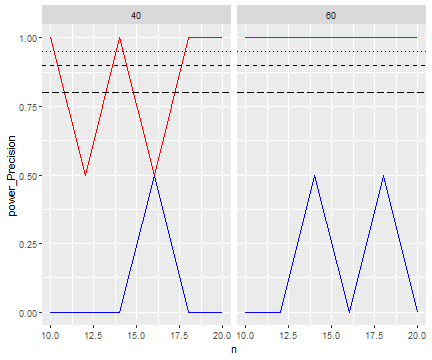

RObject{VecSxp}


In [136]:
@rput PowerfulDataframe
R"""
plot = ggplot(PowerfulDataframe) +
geom_line(aes(n,power_Precision),color="red") +
geom_line(aes(n,power_Accuracy),color="blue") +
facet_grid(.~reps) +
geom_hline(yintercept = 0.8, linetype=5) +
geom_hline(yintercept = 0.9, linetype=2) +
geom_hline(yintercept = 0.95, linetype=3)
plot
"""

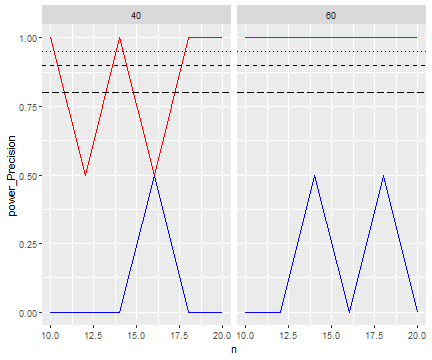

RObject{VecSxp}


In [99]:
reps

55

In [83]:
PowerfulDataframe

,n,ConditionsOfInterest,StandardValue1,StandardValue2,reps,PSE_Difference
,Int64,Int64,Int64,Int64,Int64,Float64
1,10,2,5,8,60,0.1
2,12,2,5,8,60,0.1
3,14,2,5,8,60,0.1
4,16,2,5,8,60,0.1
5,18,2,5,8,60,0.1
6,20,2,5,8,60,0.1


In [7]:
string(5)

"5"

In [74]:
    for 
  Psychometric = Psychometric %>%
    group_by(ID) %>%#
    mutate(PSE_Factor_ID = rnorm(1,1,Mean_Variability_Between),
           SD_Factor_ID = rnorm(1,1,SD_Variability_Between))
  
  Psychometric = Psychometric %>%
    mutate(
      Mean_Standard = StandardValues+StandardValues*Multiplicator_PSE_Standard,
      SD_Standard = StandardValues*Multiplicator_SD_Standard,
      Mean = (Mean_Standard + (ConditionOfInterest==ConditionOfInterest[2])*StandardValues*PSE_Difference)*PSE_Factor_ID,
      SD = abs((SD_Standard + (ConditionOfInterest==ConditionOfInterest[2])*SD_Standard*JND_Difference)*SD_Factor_ID),
      staircase_factor = rcauchy(length(reps),1,SD_ResponseFunction), 
      Presented_TestStimulusStrength = Mean*staircase_factor,
      Difference = Presented_TestStimulusStrength - StandardValues,
      AnswerProbability = pnorm(Presented_TestStimulusStrength,Mean,SD),
      Answer = as.numeric(rbernoulli(length(AnswerProbability),AnswerProbability))
    )
  
  Psychometric = Psychometric %>%
    filter(abs(staircase_factor-1) < 0.75) %>%
    group_by(ID,ConditionOfInterest,StandardValues,Difference) %>%
    mutate(Yes = sum(Answer==1),
           Total = length(ConditionOfInterest))
  
  Psychometric
}
""";

MethodError: MethodError: no method matching sexpclass(::Millisecond)
Closest candidates are:
  sexpclass(!Matched::Nothing) at C:\Users\bjoer\.julia\packages\RCall\g7dhB\src\convert\default.jl:218
  sexpclass(!Matched::Missing) at C:\Users\bjoer\.julia\packages\RCall\g7dhB\src\convert\default.jl:219
  sexpclass(!Matched::Symbol) at C:\Users\bjoer\.julia\packages\RCall\g7dhB\src\convert\default.jl:222
  ...